In [1]:
import rasterio as rio
from rasterio import mask
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling

import numpy as np

import boto3
import s3fs
import skimage

from shapely import geometry
from functools import partial
import pyproj
from shapely.ops import transform

import re
import os 
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

import matplotlib.pyplot as plt
%matplotlib inline

# Analysis of Accuracy of Predictions



In [2]:
aws_session = boto3.Session(profile_name = 'esip')

**Scope**: Predictions from a single ASO collect from Tuolumne, 20180528. 

In [3]:
fs = s3fs.S3FileSystem(session = aws_session)
predictions =  [d.split('/')[1] for d in fs.ls('planet-snowcover-predictions') if re.match(".*20180528.*_clip", d)]

We'll pair these predictions with ASO.

In [22]:
with rio.Env(profile_name = 'esip'):
    aso_projected = rio.open("s3://planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary.tif")

In [23]:
aso_projected.name

's3://planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary.tif'

In [24]:
predictions[5]

'20180528_181110_1025_3B_AnalyticMS_SR_clip'

In [25]:
with rio.Env(profile_name = 'esip'): 
    p = rio.open("s3://planet-snowcover-predictions/{}/merged.tif".format(predictions[5]))

In [26]:
def crop_aso_mask(aso, pred):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:{}'.format(aso_projected.crs['init'].split(":")[1]))) # destination coordinate system
    masked_aso = mask.mask(aso_projected, [transform(project, geometry.Polygon.from_bounds(*pred.bounds))], crop=True)
    
    prof = aso.profile
    prof.update(
        driver = 'GTiff',
        transform = masked_aso[1],
        width = masked_aso[0].squeeze().shape[0],
        height = masked_aso[0].squeeze().shape[1]
    )
    
    fname = os.path.basename(aso_projected.name)
    print(fname)
    
    with rio.open("/tmp/masked_{}".format(fname), 'w', **prof) as f:
        f.write(masked_aso[0].squeeze(), 1)
        
    return rio.open("/tmp/masked_{}".format(fname))

In [27]:
a = crop_aso_mask(aso_projected, p)

ASO_3M_SD_USCATE_20180528_binary.tif


In [28]:
a.shape

(8467, 4388)

In [29]:
a_resamp = a.read(out_shape = p.shape, resampling = Resampling.bilinear)

In [30]:
pred_mask = (p.read().squeeze() == 1).astype(int)
aso_mask = (a_resamp.squeeze() == 1).astype(int)

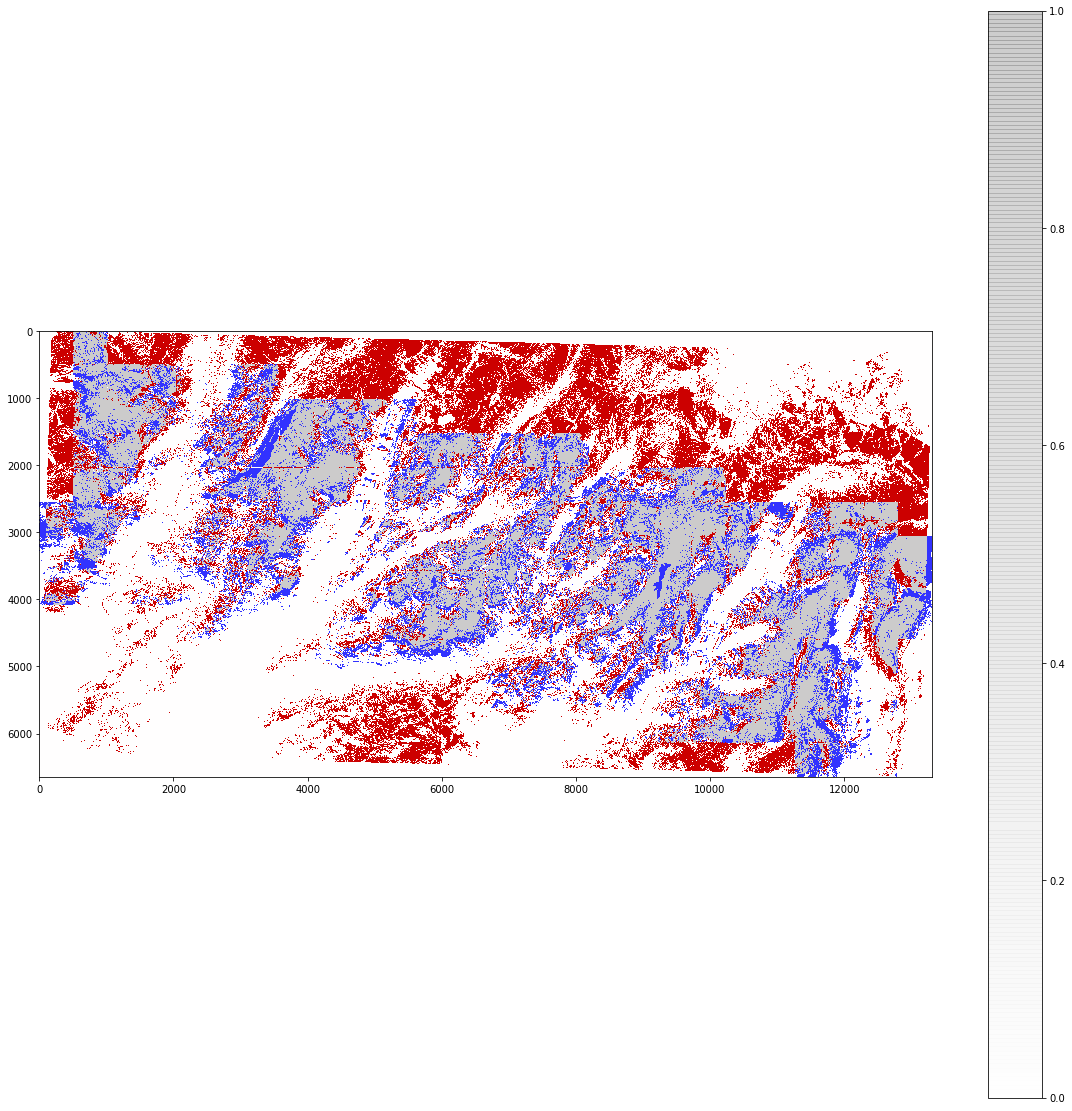

In [20]:
fig = plt.figure(figsize=(20,20))
plt.imshow(aso_mask - pred_mask, cmap='bwr')
plt.imshow(aso_mask, cmap='binary', alpha=0.2)

plt.colorbar()

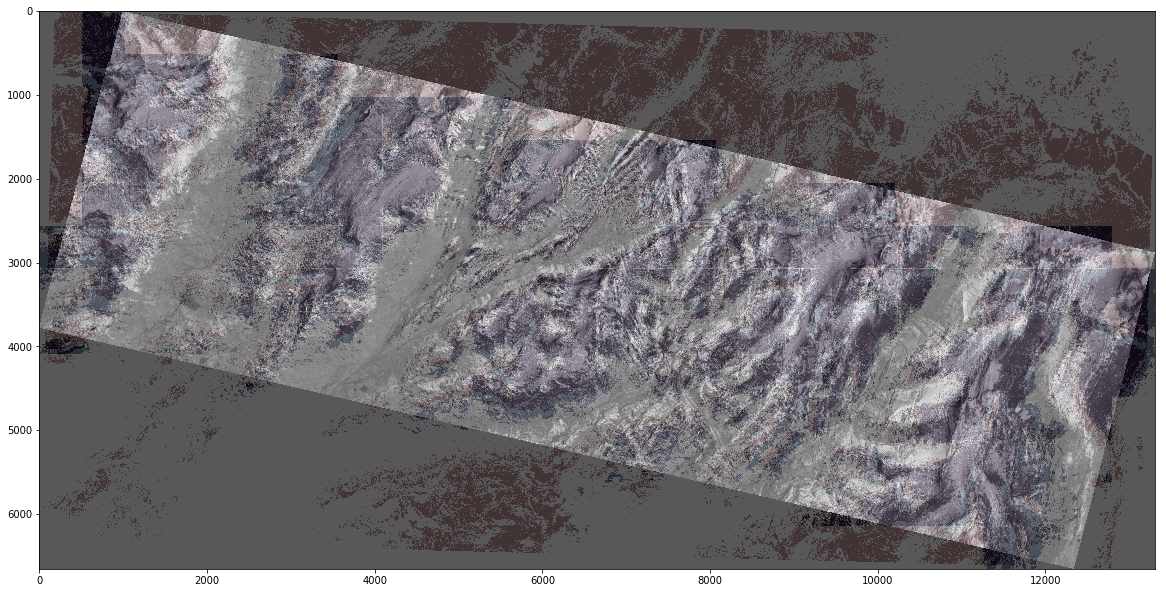

In [33]:
with rio.Env(profile_name='esip'):
    fig = plt.figure(figsize=(20,20))
    baseimg = rio.open("s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/4/files/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif")
#     rgb = np.moveaxis(baseimg.read(out_shape = p.shape)[[2, 1, 0]], 0, 2)
#     rgb = skimage.exposure.rescale_intensity(skimage.exposure.equalize_adapthist(rgb), in_range = (0, .62))
    nir = baseimg.read(indexes = 4, out_shape = p.shape)
#     plt.imshow(rgb)
    plt.imshow(nir.squeeze(), cmap='binary_r')
    
    plt.imshow(aso_mask, cmap='Reds', alpha=0.2)
    plt.imshow(pred_mask, cmap='Blues', alpha=0.2)
    #     plt.imshow(aso_mask, cmap='binary', alpha=0.2)



In [35]:
baseimg.read(out_shape = (baseimg.height // 2, baseimg.height // 2), resampling=Resampling.bilinear)

MemoryError: 

In [34]:
baseimg.height // 2

2361

In [10]:
baseimg.shape


(4722, 8920)

In [11]:
baseimg.width

8920